In [2]:
import numpy as np

In [6]:
def simulate_ising(L, beta, Nsteps):
  config=initilize_config(L)
  for _ in range(Nsteps):
    config=metropolis_step(config, beta)
  return config

In [7]:
def initilize_config(L):
  return np.random.choice([-1,1], size=(L,L))

In [8]:
def metropolis_step(config, beta):
  """
  One step update of metropolis algorithm

  Input
  - config: current spin configuration
  - beta: inverse temperature

  Output
  - config: updated configuration
  """
  L=config.shape[0]
  for _ in range(L*L):
    i,j = np.random.randint(0,L,size=2)
    S=config[i,j]
    # nearest neighbour spins
    S_nbr=config[(i+1)%L,j]+config[(i-1)%L,j]+config[i,(j-1)%L]+config[i,(j+1)%L]
    dE=2*S*S_nbr
    if dE<0 or np.random.rand()<np.exp(-beta*dE):
      config[i,j]*=-1
  return config

In [10]:
import matplotlib.pyplot as plt

In [20]:
def visualize_config(config):
  plt.imshow(config, cmap="bwr", vmin=-1, vmax=1)
  plt.colorbar(label="Spin")
  plt.title("Ising spin configuration")
  plt.axis("off")
  plt.show()

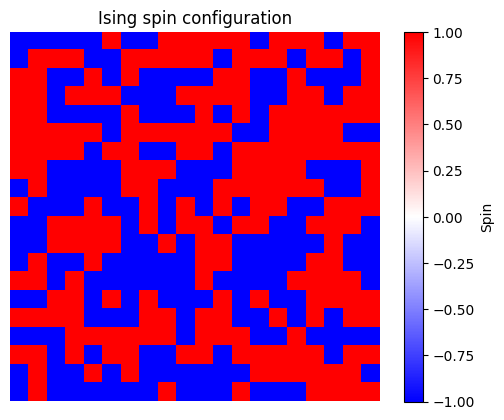

In [30]:
visualize_config(simulate_ising(20,.1,100))

In [40]:
def generate_dataset(L, Ts, Nsamples, Nsteps):
  """
  Generate dataset for supervised learning

  Input
  - L: lattice size
  - Ts: temperature range
  - Nsamples: size of samples for each temperature
  - Nsteps: steps of metropolitan algorithm

  Output
  - np.array(data): predictor
  - np.array(labels): target
  """
  data=[]
  labels=[]
  Tc = 2/np.log(1+np.sqrt(2)) # 2.269
  for T in Ts:
    beta=1/T
    for _ in range(Nsamples):
      config=simulate_ising(L,beta,Nsteps)
      data.append(config.copy())
      labels.append(1 if T<Tc else 0) # ordered or not
  return np.array(data), np.array(labels)

In [97]:
L_=8
Ts_=np.linspace(1.,4.,20)
Nsamples_=100
Nsteps_=100

xs_,ys_=generate_dataset(L_,Ts_,Nsamples_,Nsteps_)

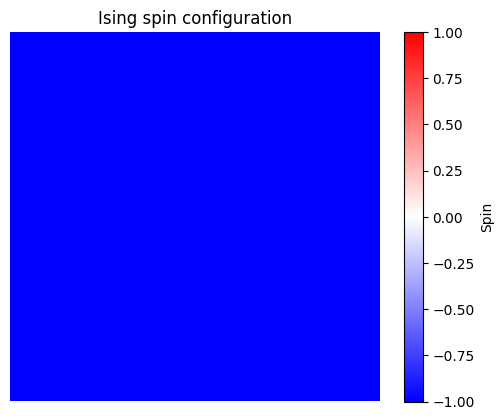

Label: 1


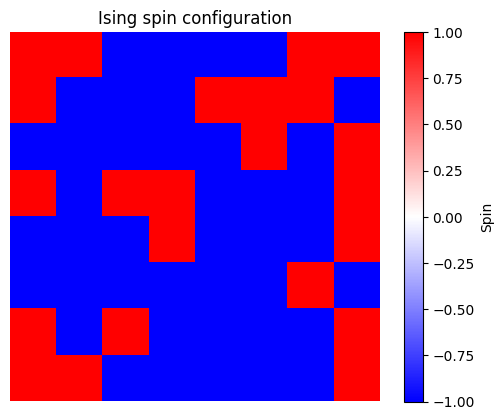

Label: 0


In [98]:
visualize_config(xs_[0])
print("Label:", ys_[0])
visualize_config(xs_[-1])
print("Label:", ys_[-1])

In [99]:
# np.savez("ising_data.npz", X=xs_, y=ys_)

In [100]:
# data = np.load("ising_data.npz")
# xs_, ys_ = data["X"], data["y"]

In [101]:
xs_ = xs_.reshape(
    -1, # auto estimation for sample size
    L_,L_,
    1 # gray scale images cf. 3 for RGB
    ).astype("float64")
ys_=ys_.astype("int")

In [102]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
!wget https://github.com/Hiromu-USHIHARA/IsingClassification/raw/main/model.h5
model = tf.keras.models.load_model("model.h5")

In [103]:
model=models.Sequential([
    layers.Input((L_,L_,1)),
    layers.Conv2D(32,(3,3),activation="relu", padding="same"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu", padding="same"),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(2,activation="softmax")
])

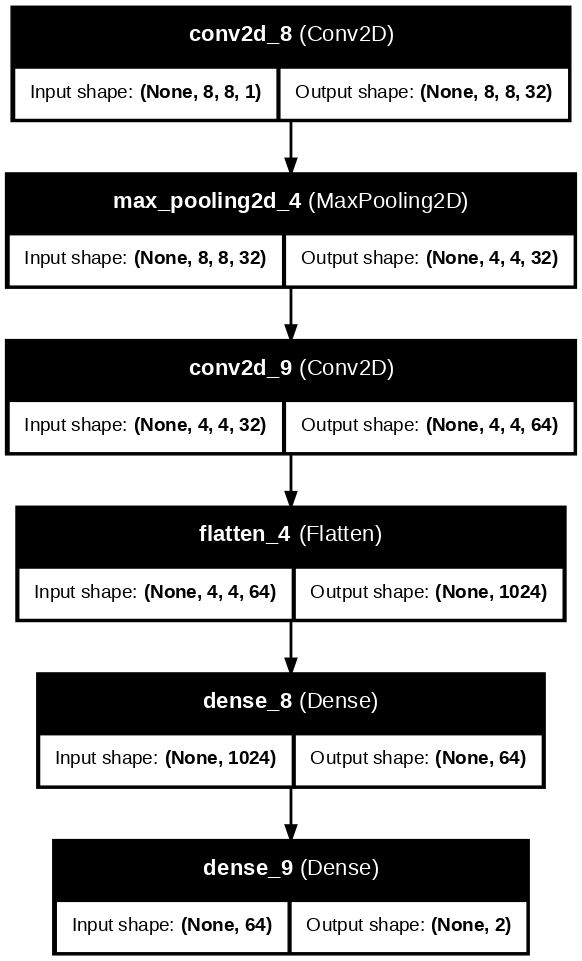

In [104]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model,
           to_file="model.png",
           show_shapes=True,
           show_layer_names=True,
           dpi=100)

Image(filename="model.png", width=400)

In [105]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [106]:
model.fit(xs_, ys_, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7621 - loss: 0.4422 - val_accuracy: 0.9975 - val_loss: 0.0242
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9104 - loss: 0.2291 - val_accuracy: 0.9950 - val_loss: 0.0236
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9049 - loss: 0.2374 - val_accuracy: 0.9900 - val_loss: 0.0544
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9205 - loss: 0.2126 - val_accuracy: 0.9950 - val_loss: 0.0204
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9295 - loss: 0.1913 - val_accuracy: 0.9925 - val_loss: 0.0732
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9297 - loss: 0.1912 - val_accuracy: 0.9875 - val_loss: 0.0959
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9201 - loss: 0.2154 - val_accuracy: 0.9975 - val_loss: 0.0165
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9302 - loss: 0.1799 - val_accuracy: 0.9875 - val_lo

In [107]:
# model.save("ising_cnn_model.h5")

In [108]:
# model = tf.keras.models.load_model("ising_cnn_model.h5")

In [109]:
def check():
  id = np.random.randint(0,len(xs_)-1)
  sample=xs_[id].reshape(1,L_,L_,1)

  visualize_config(sample.reshape(L_,L_))
  print("Correct label:", ys_[id])

  prediction=model.predict(sample, verbose=0)
  pred_label=prediction.argmax()
  print("Predicted label:", pred_label)

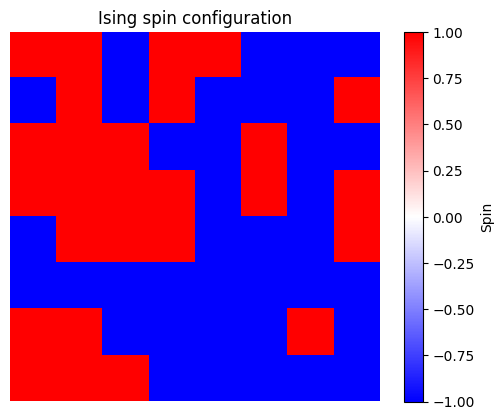

Correct label: 0
Predicted label: 0


In [110]:
check()

In [111]:
def test(mod,L,Ts=Ts_,Nsamples=Nsamples_,Nsteps=Nsteps_):
  probs=[]

  for T in Ts:
    beta=1/T
    configs=[simulate_ising(L,beta,Nsteps) for _ in range(Nsamples)]
    inputs=np.array(configs).reshape(-1,L,L,1).astype("float64")
    predictions=mod.predict(inputs,verbose=0)
    ordered_probs=predictions[:,1].mean()
    probs.append(ordered_probs)

  plt.figure(figsize=(16,9))
  plt.plot(Ts,probs,label="Predicted ordered probability")
  plt.axvline(2/np.log(1+np.sqrt(2)), color="gray", linestyle="--", label="Tc (theory)")
  plt.xlabel("Temperature")
  plt.legend()
  plt.grid(True)
  plt.show()

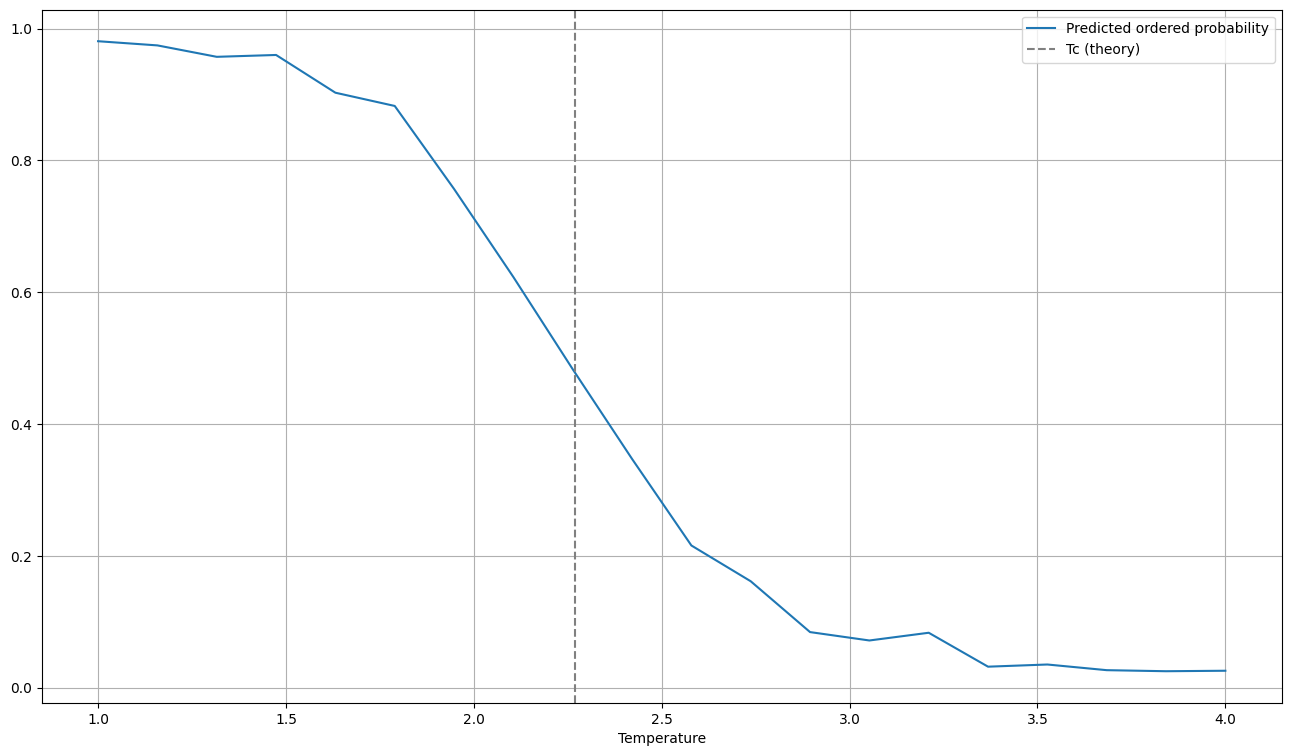

In [112]:
test(model, L_)